## 1. Import Libraries

In [1]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import eda_helper_functions
import helper


from sklearn.ensemble import IsolationForest

## 2. Read the Training Data

In [2]:
file_path = r"U:\nlp_project\flight-prices-prediction\data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-27,Delhi,Cochin,20:55:00,12:35:00,940,1.0,In-flight meal not included,12898
1,Jet Airways,2019-06-12,Kolkata,Banglore,18:55:00,16:20:00,1285,1.0,No Info,13044
2,Air India,2019-05-18,Delhi,Cochin,09:45:00,09:25:00,1420,2.0,No Info,10975
3,Indigo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,90,0.0,No Info,2227
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,02:55:00,04:20:00,85,0.0,No Info,5678
...,...,...,...,...,...,...,...,...,...,...
6689,Spicejet,2019-06-09,Kolkata,Banglore,11:35:00,18:50:00,435,1.0,No Info,8479
6690,Multiple Carriers,2019-05-09,Delhi,Cochin,10:00:00,01:30:00,930,1.0,No Info,15078
6691,Air India,2019-05-18,Delhi,Cochin,12:00:00,07:40:00,1180,2.0,No Info,8603
6692,Air Asia,2019-05-18,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,8759


### 2.1 Fixing Data Types

In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [4]:
train = train.assign(**{
	col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
	for col in ["date_of_journey", "dep_time", "arrival_time"]
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [5]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-27,Delhi,Cochin,2024-10-06 20:55:00,2024-10-06 12:35:00,940,1.0,In-flight meal not included,12898
1,Jet Airways,2019-06-12,Kolkata,Banglore,2024-10-06 18:55:00,2024-10-06 16:20:00,1285,1.0,No Info,13044
2,Air India,2019-05-18,Delhi,Cochin,2024-10-06 09:45:00,2024-10-06 09:25:00,1420,2.0,No Info,10975
3,Indigo,2019-06-03,Mumbai,Hyderabad,2024-10-06 21:20:00,2024-10-06 22:50:00,90,0.0,No Info,2227
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,2024-10-06 02:55:00,2024-10-06 04:20:00,85,0.0,No Info,5678
...,...,...,...,...,...,...,...,...,...,...
6689,Spicejet,2019-06-09,Kolkata,Banglore,2024-10-06 11:35:00,2024-10-06 18:50:00,435,1.0,No Info,8479
6690,Multiple Carriers,2019-05-09,Delhi,Cochin,2024-10-06 10:00:00,2024-10-06 01:30:00,930,1.0,No Info,15078
6691,Air India,2019-05-18,Delhi,Cochin,2024-10-06 12:00:00,2024-10-06 07:40:00,1180,2.0,No Info,8603
6692,Air Asia,2019-05-18,Delhi,Cochin,2024-10-06 07:55:00,2024-10-06 13:25:00,330,1.0,No Info,8759


## 3. High-level Summary of Data

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6694 non-null   object        
 1   date_of_journey  6694 non-null   datetime64[ns]
 2   source           6694 non-null   object        
 3   destination      6694 non-null   object        
 4   dep_time         6694 non-null   datetime64[ns]
 5   arrival_time     6694 non-null   datetime64[ns]
 6   duration         6694 non-null   int64         
 7   total_stops      6694 non-null   float64       
 8   additional_info  6694 non-null   object        
 9   price            6694 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 523.1+ KB


In [7]:
train.describe(include="number")

,duration,total_stops,price
count,6694.000000,6694.000000,6694.000000
mean,637.633702,0.812668,9092.553331
std,504.395941,0.658143,4670.489223
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5277.000000
50%,515.000000,1.000000,8372.000000
75%,925.000000,1.000000,12373.000000
max,2860.000000,3.000000,79512.000000


In [8]:
(
	train
	.assign(total_stops=train["total_stops"].astype(object))
	.describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,6694,6694,6694,6694.0,6694
unique,9,5,6,4.0,8
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,2387,2781,2781,3638.0,5226


## 4. High-level analysis of Missing Values

In [9]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


## 5. High-level analysis of Outliers

In [10]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [11]:
(
	train
	.assign(outlier=forest.fit_predict(
		train
		.drop(columns="price")
		.select_dtypes(include="number")
	))
	.query("outlier == -1")
	# .duration
	# .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
1,Jet Airways,2019-06-12,Kolkata,Banglore,2024-10-06 18:55:00,2024-10-06 16:20:00,1285,1.0,No Info,13044,-1
2,Air India,2019-05-18,Delhi,Cochin,2024-10-06 09:45:00,2024-10-06 09:25:00,1420,2.0,No Info,10975,-1
3,Indigo,2019-06-03,Mumbai,Hyderabad,2024-10-06 21:20:00,2024-10-06 22:50:00,90,0.0,No Info,2227,-1
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,2024-10-06 02:55:00,2024-10-06 04:20:00,85,0.0,No Info,5678,-1
7,Jet Airways,2019-05-09,Delhi,Cochin,2024-10-06 23:05:00,2024-10-06 04:25:00,1760,2.0,No Info,15129,-1
...,...,...,...,...,...,...,...,...,...,...,...
6676,Jet Airways,2019-05-24,Kolkata,Banglore,2024-10-06 18:55:00,2024-10-06 23:35:00,1720,1.0,In-flight meal not included,10844,-1
6681,Jet Airways,2019-06-21,Delhi,Cochin,2024-10-06 11:00:00,2024-10-06 14:15:00,195,0.0,In-flight meal not included,4256,-1
6682,Jet Airways,2019-05-01,Kolkata,Banglore,2024-10-06 09:35:00,2024-10-06 14:25:00,1730,1.0,No Info,11467,-1
6687,Jet Airways,2019-06-15,Delhi,Cochin,2024-10-06 21:25:00,2024-10-06 12:35:00,910,2.0,In-flight meal not included,9905,-1


## 6. Pair Plots

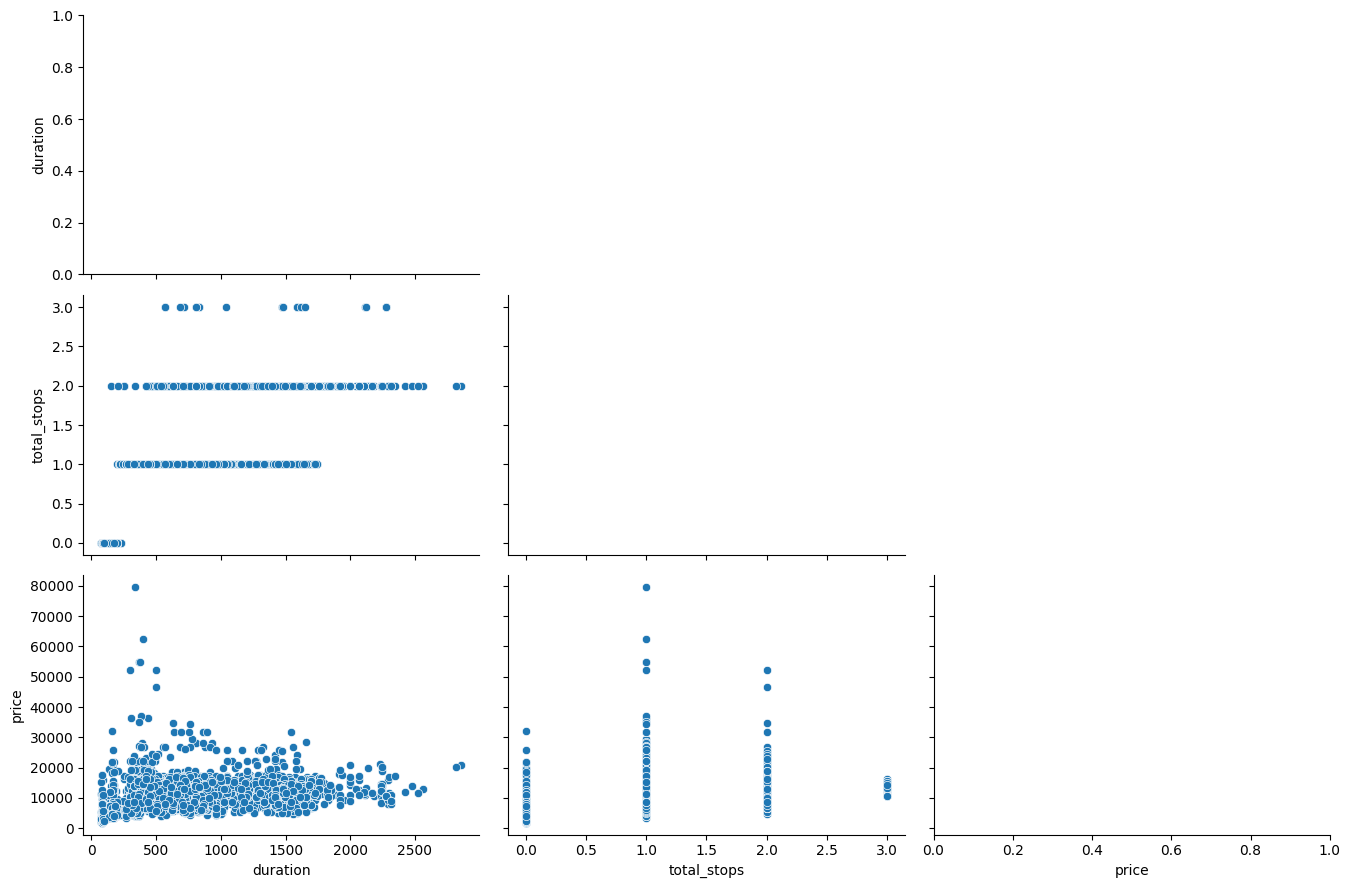

In [12]:
eda_helper_functions.pair_plots(train)

## 7. Correlation Analysis

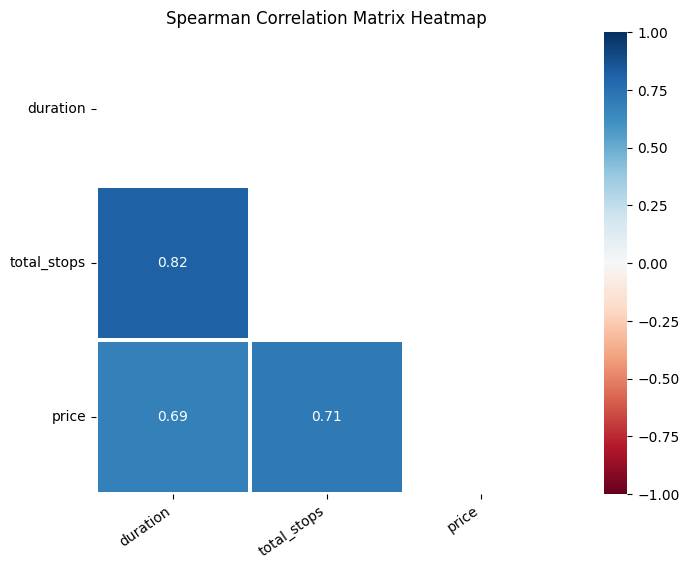

In [13]:
eda_helper_functions.correlation_heatmap(train)

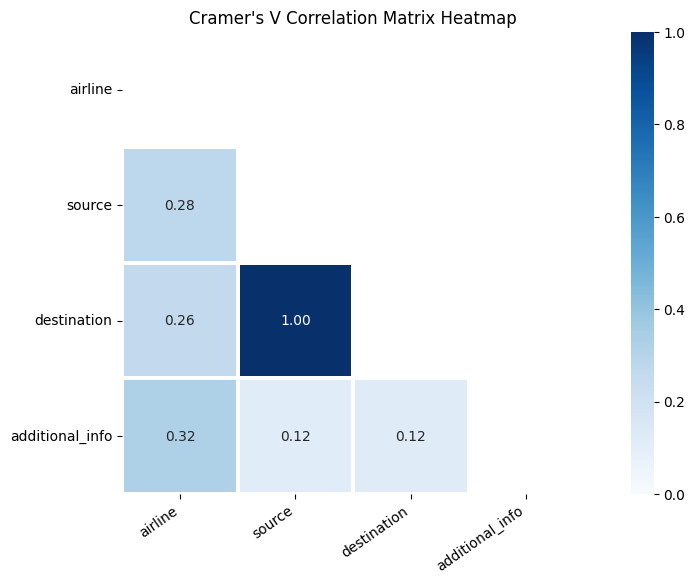

In [14]:
eda_helper_functions.cramersV_heatmap(train)

## 8. Detailed Analysis

In [15]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airline

In [16]:
train.airline

0             Jet Airways
1             Jet Airways
2               Air India
3                  Indigo
4             Jet Airways
              ...        
6689             Spicejet
6690    Multiple Carriers
6691            Air India
6692             Air Asia
6693    Multiple Carriers
Name: airline, Length: 6694, dtype: object

In [17]:
eda_helper_functions.cat_summary(train, "airline")

0             Jet Airways
1             Jet Airways
2               Air India
3                  Indigo
4             Jet Airways
              ...        
6689             Spicejet
6690    Multiple Carriers
6691            Air India
6692             Air Asia
6693    Multiple Carriers
Name: airline, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,9
top,Jet Airways
freq,2387


,count,percentage
category,,
Jet Airways,2387,0.356588
Indigo,1281,0.191365
Air India,1087,0.162384
Multiple Carriers,768,0.114730
Spicejet,534,0.079773
Vistara,301,0.044966
Air Asia,215,0.032118
Goair,120,0.017927
Trujet,1,0.000149


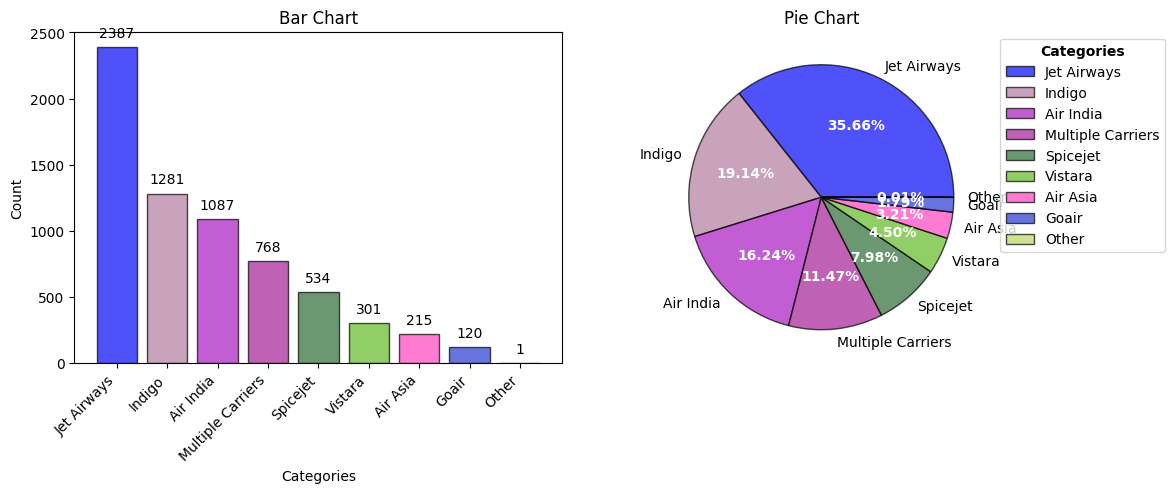

In [18]:
eda_helper_functions.cat_univar_plots(train, "airline",show_wordcloud=False, k=8)

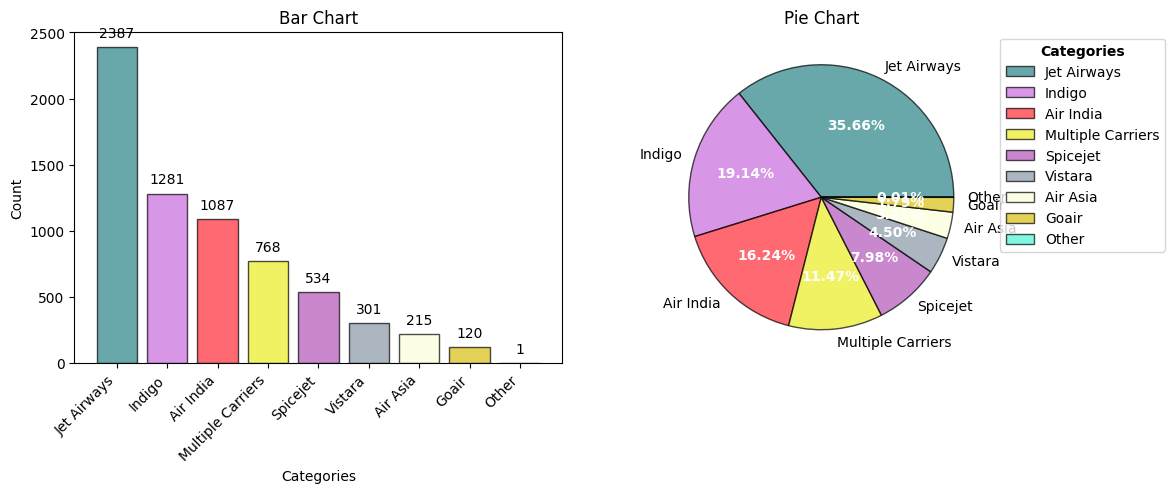

In [19]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False, k=8)

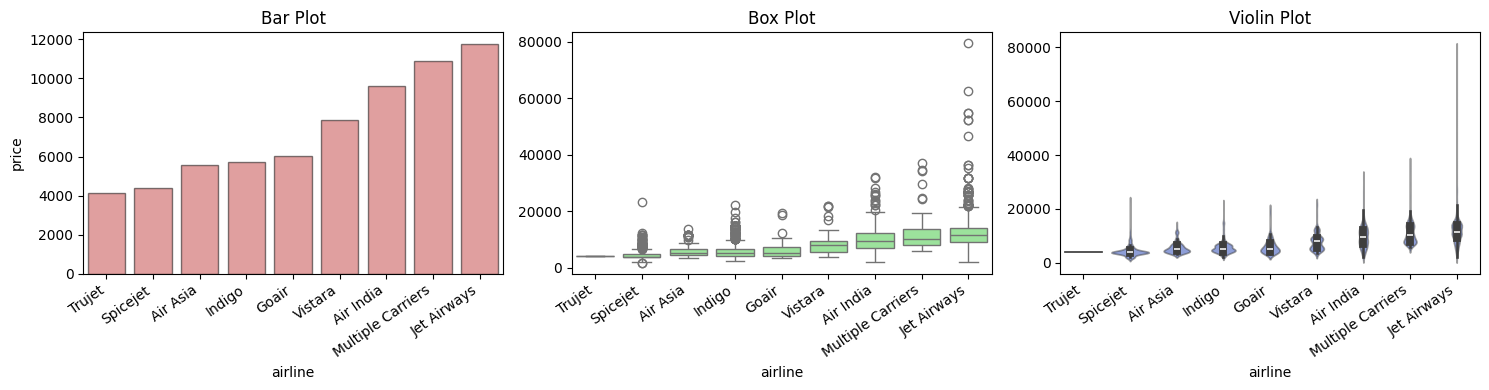

In [20]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="airline"
)

In [21]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 446.0707433362749
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3062.6099595740966
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


In [22]:
# airline_grid = sns.FacetGrid(
# 	data=train,
# 	col="destination",
# 	col_wrap=3,
# 	height=4,
# 	aspect=1.2,
# 	sharey=True
# )

# airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

# for ax in airline_grid.axes[3:]:
# 	eda_helper_functions.rotate_xlabels(ax)

### 8.2 date_of_journey

In [23]:
train.date_of_journey

0      2019-05-27
1      2019-06-12
2      2019-05-18
3      2019-06-03
4      2019-04-01
          ...    
6689   2019-06-09
6690   2019-05-09
6691   2019-05-18
6692   2019-05-18
6693   2019-04-09
Name: date_of_journey, Length: 6694, dtype: datetime64[ns]

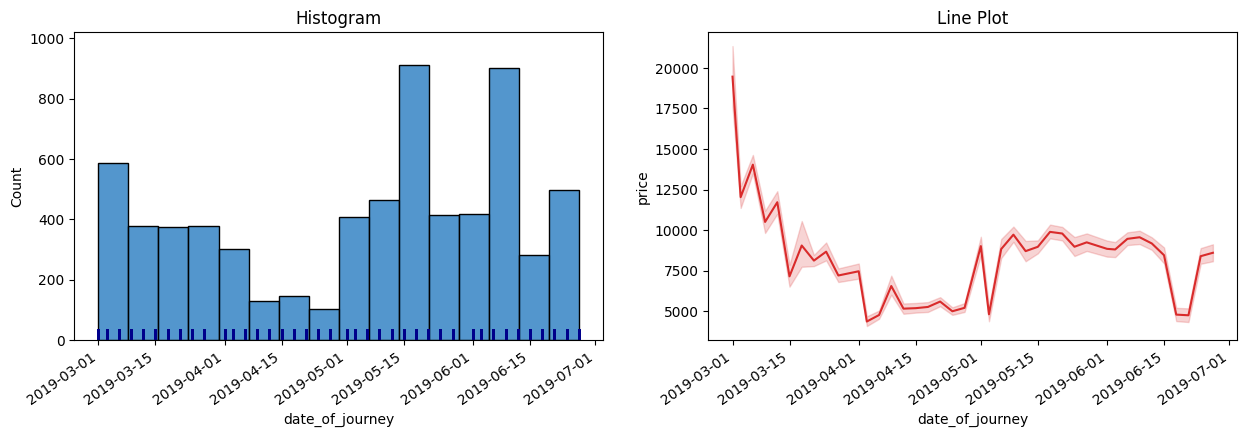

In [24]:
eda_helper_functions.dt_univar_plots(
	data=train,
	var="date_of_journey",
	target="price"
)

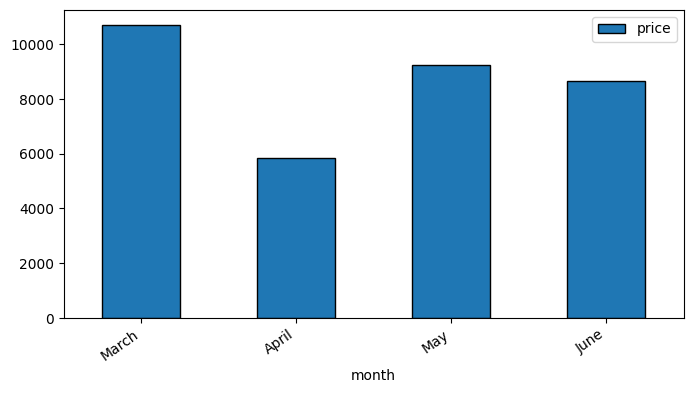

In [25]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="M"))
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

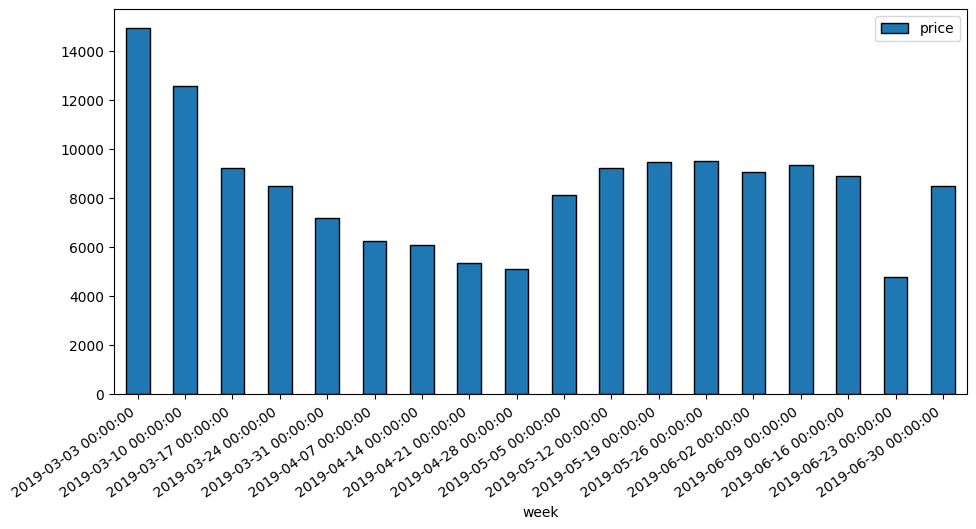

In [26]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="W"))
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(11, 5),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

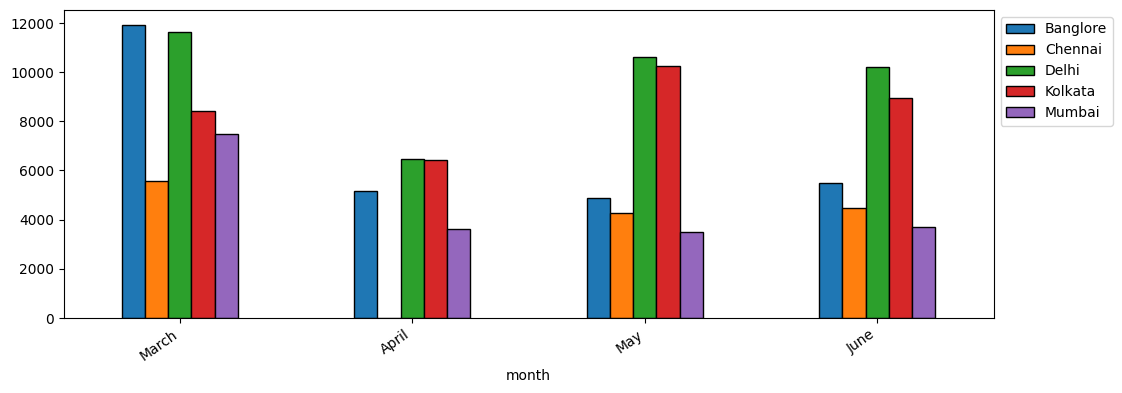

In [27]:
(
	train
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

### 8.3 dep_time

In [28]:
train.dep_time

0      2024-10-06 20:55:00
1      2024-10-06 18:55:00
2      2024-10-06 09:45:00
3      2024-10-06 21:20:00
4      2024-10-06 02:55:00
               ...        
6689   2024-10-06 11:35:00
6690   2024-10-06 10:00:00
6691   2024-10-06 12:00:00
6692   2024-10-06 07:55:00
6693   2024-10-06 08:00:00
Name: dep_time, Length: 6694, dtype: datetime64[ns]

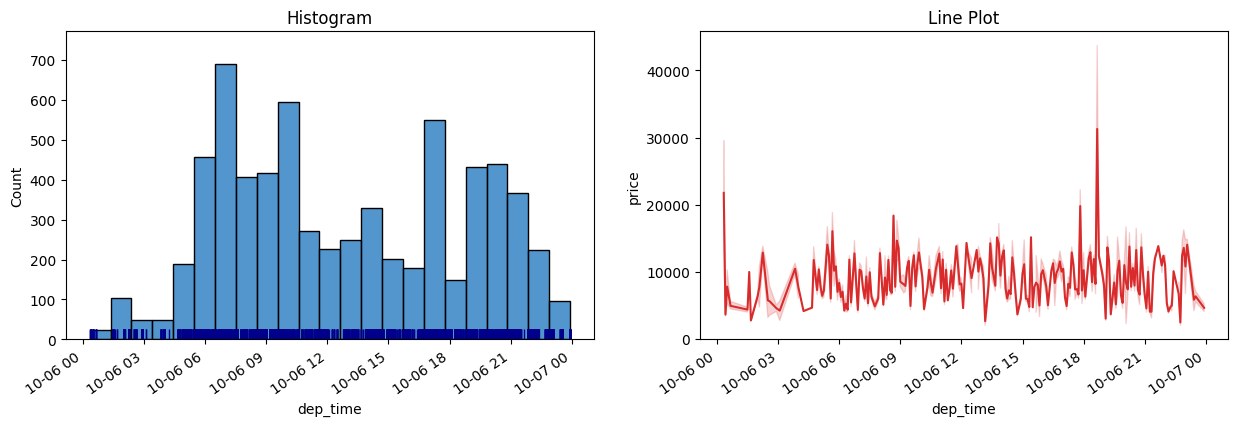

In [29]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

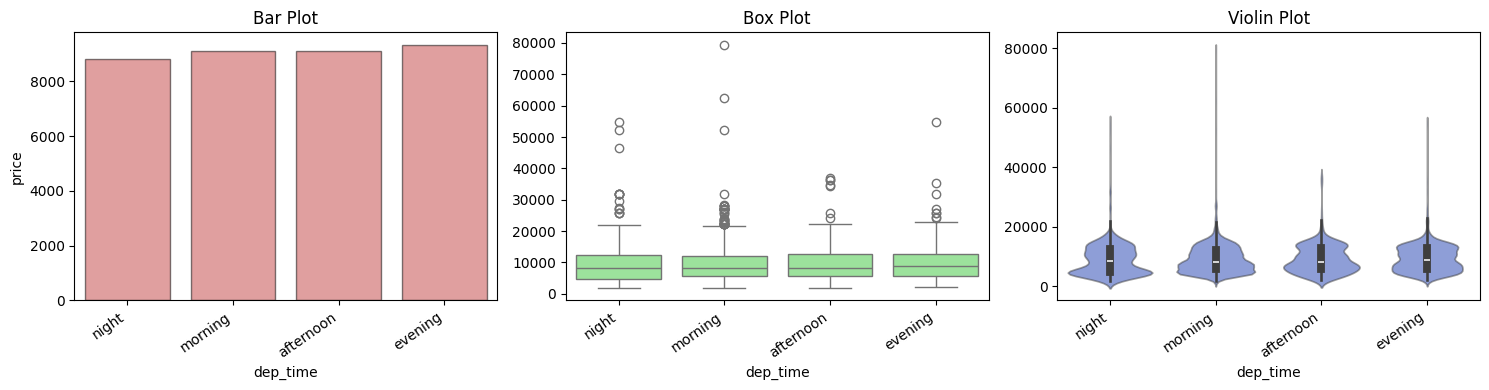

In [30]:
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

### 8.4 duration

In [31]:
train.duration

0        940
1       1285
2       1420
3         90
4         85
        ... 
6689     435
6690     930
6691    1180
6692     330
6693     660
Name: duration, Length: 6694, dtype: int64

In [32]:
eda_helper_functions.num_summary(train, "duration")

0        940
1       1285
2       1420
3         90
4         85
        ... 
6689     435
6690     930
6691    1180
6692     330
6693     660
Name: duration, Length: 6694, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,value
percentile,
0,75.00
5,90.00
10,145.00
25,170.00
50,515.00
75,925.00
90,1443.50
95,1596.75
99,1925.00


,value
mean,637.633702
trimmed mean (5%),603.744607
trimmed mean (10%),575.500373
median,515.000000


,value
var,254415.264879
std,504.395941
IQR,755.000000
mad,345.000000
coef_variance,0.791043


,value
skewness,0.902919
kurtosis,-0.006774


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 1.4148237388305426e-56
Test Statistic       : 0.8882864294027539
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 242.1831336451669
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [33]:
train.duration.quantile([0.25, 0.5, 0.75])

0.25    170.0
0.50    515.0
0.75    925.0
Name: duration, dtype: float64

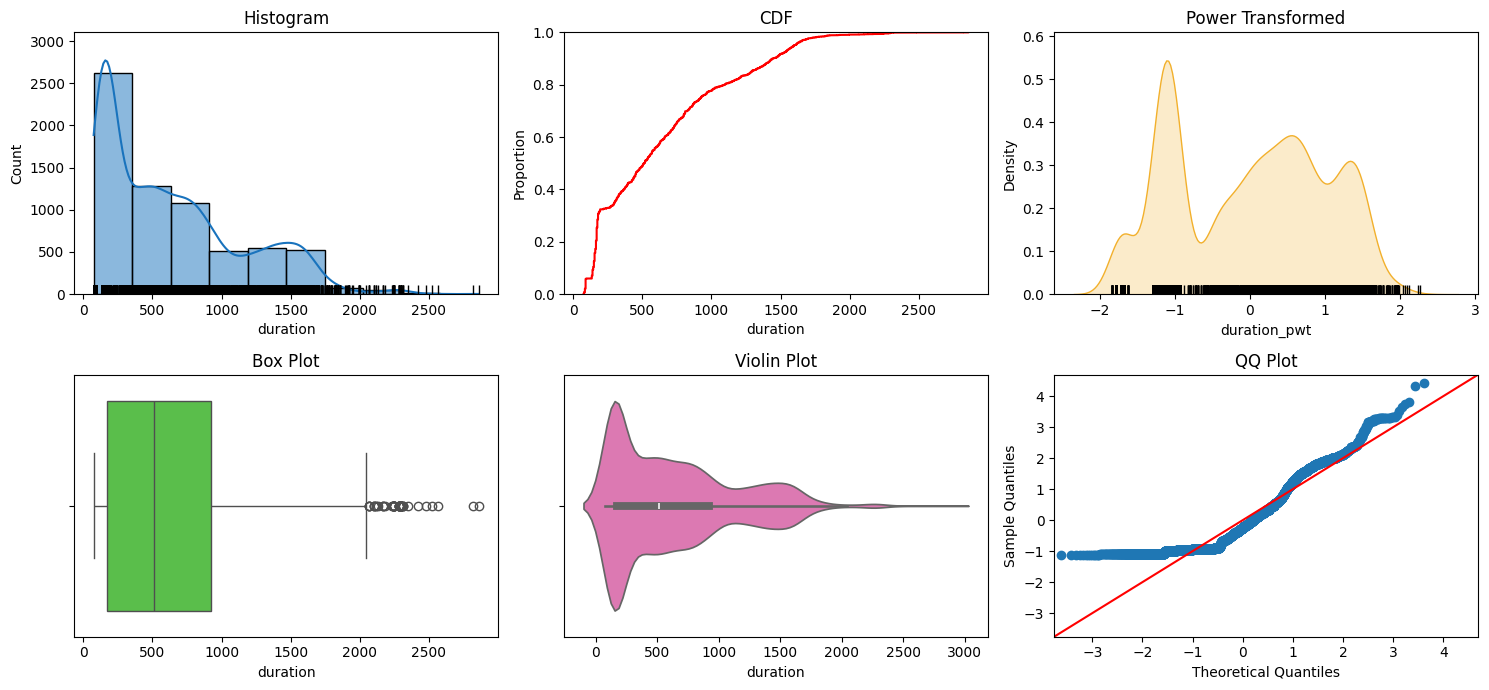

In [34]:
eda_helper_functions.num_univar_plots(train, "duration")

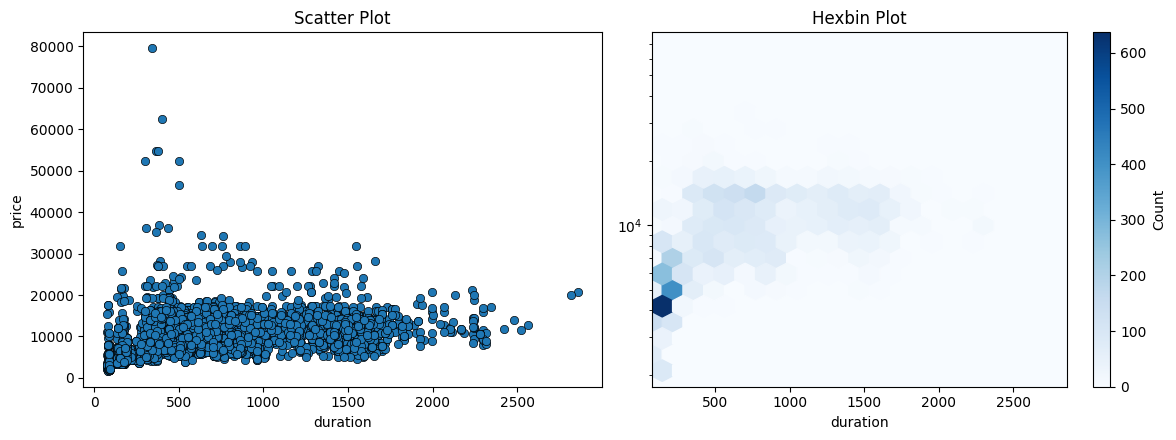

In [35]:
eda_helper_functions.num_bivar_plots(
	train,
	"duration",
	"price",
	hexbin_kwargs=dict(
		yscale="log",
		gridsize=20,
		cmap="Blues"
	)
)

In [36]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.48835802027266345
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.685936761630648
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


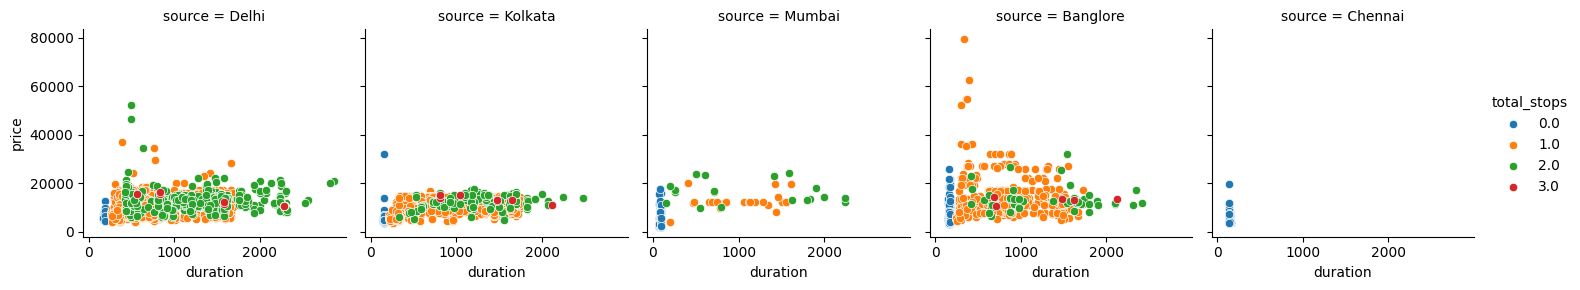

In [37]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

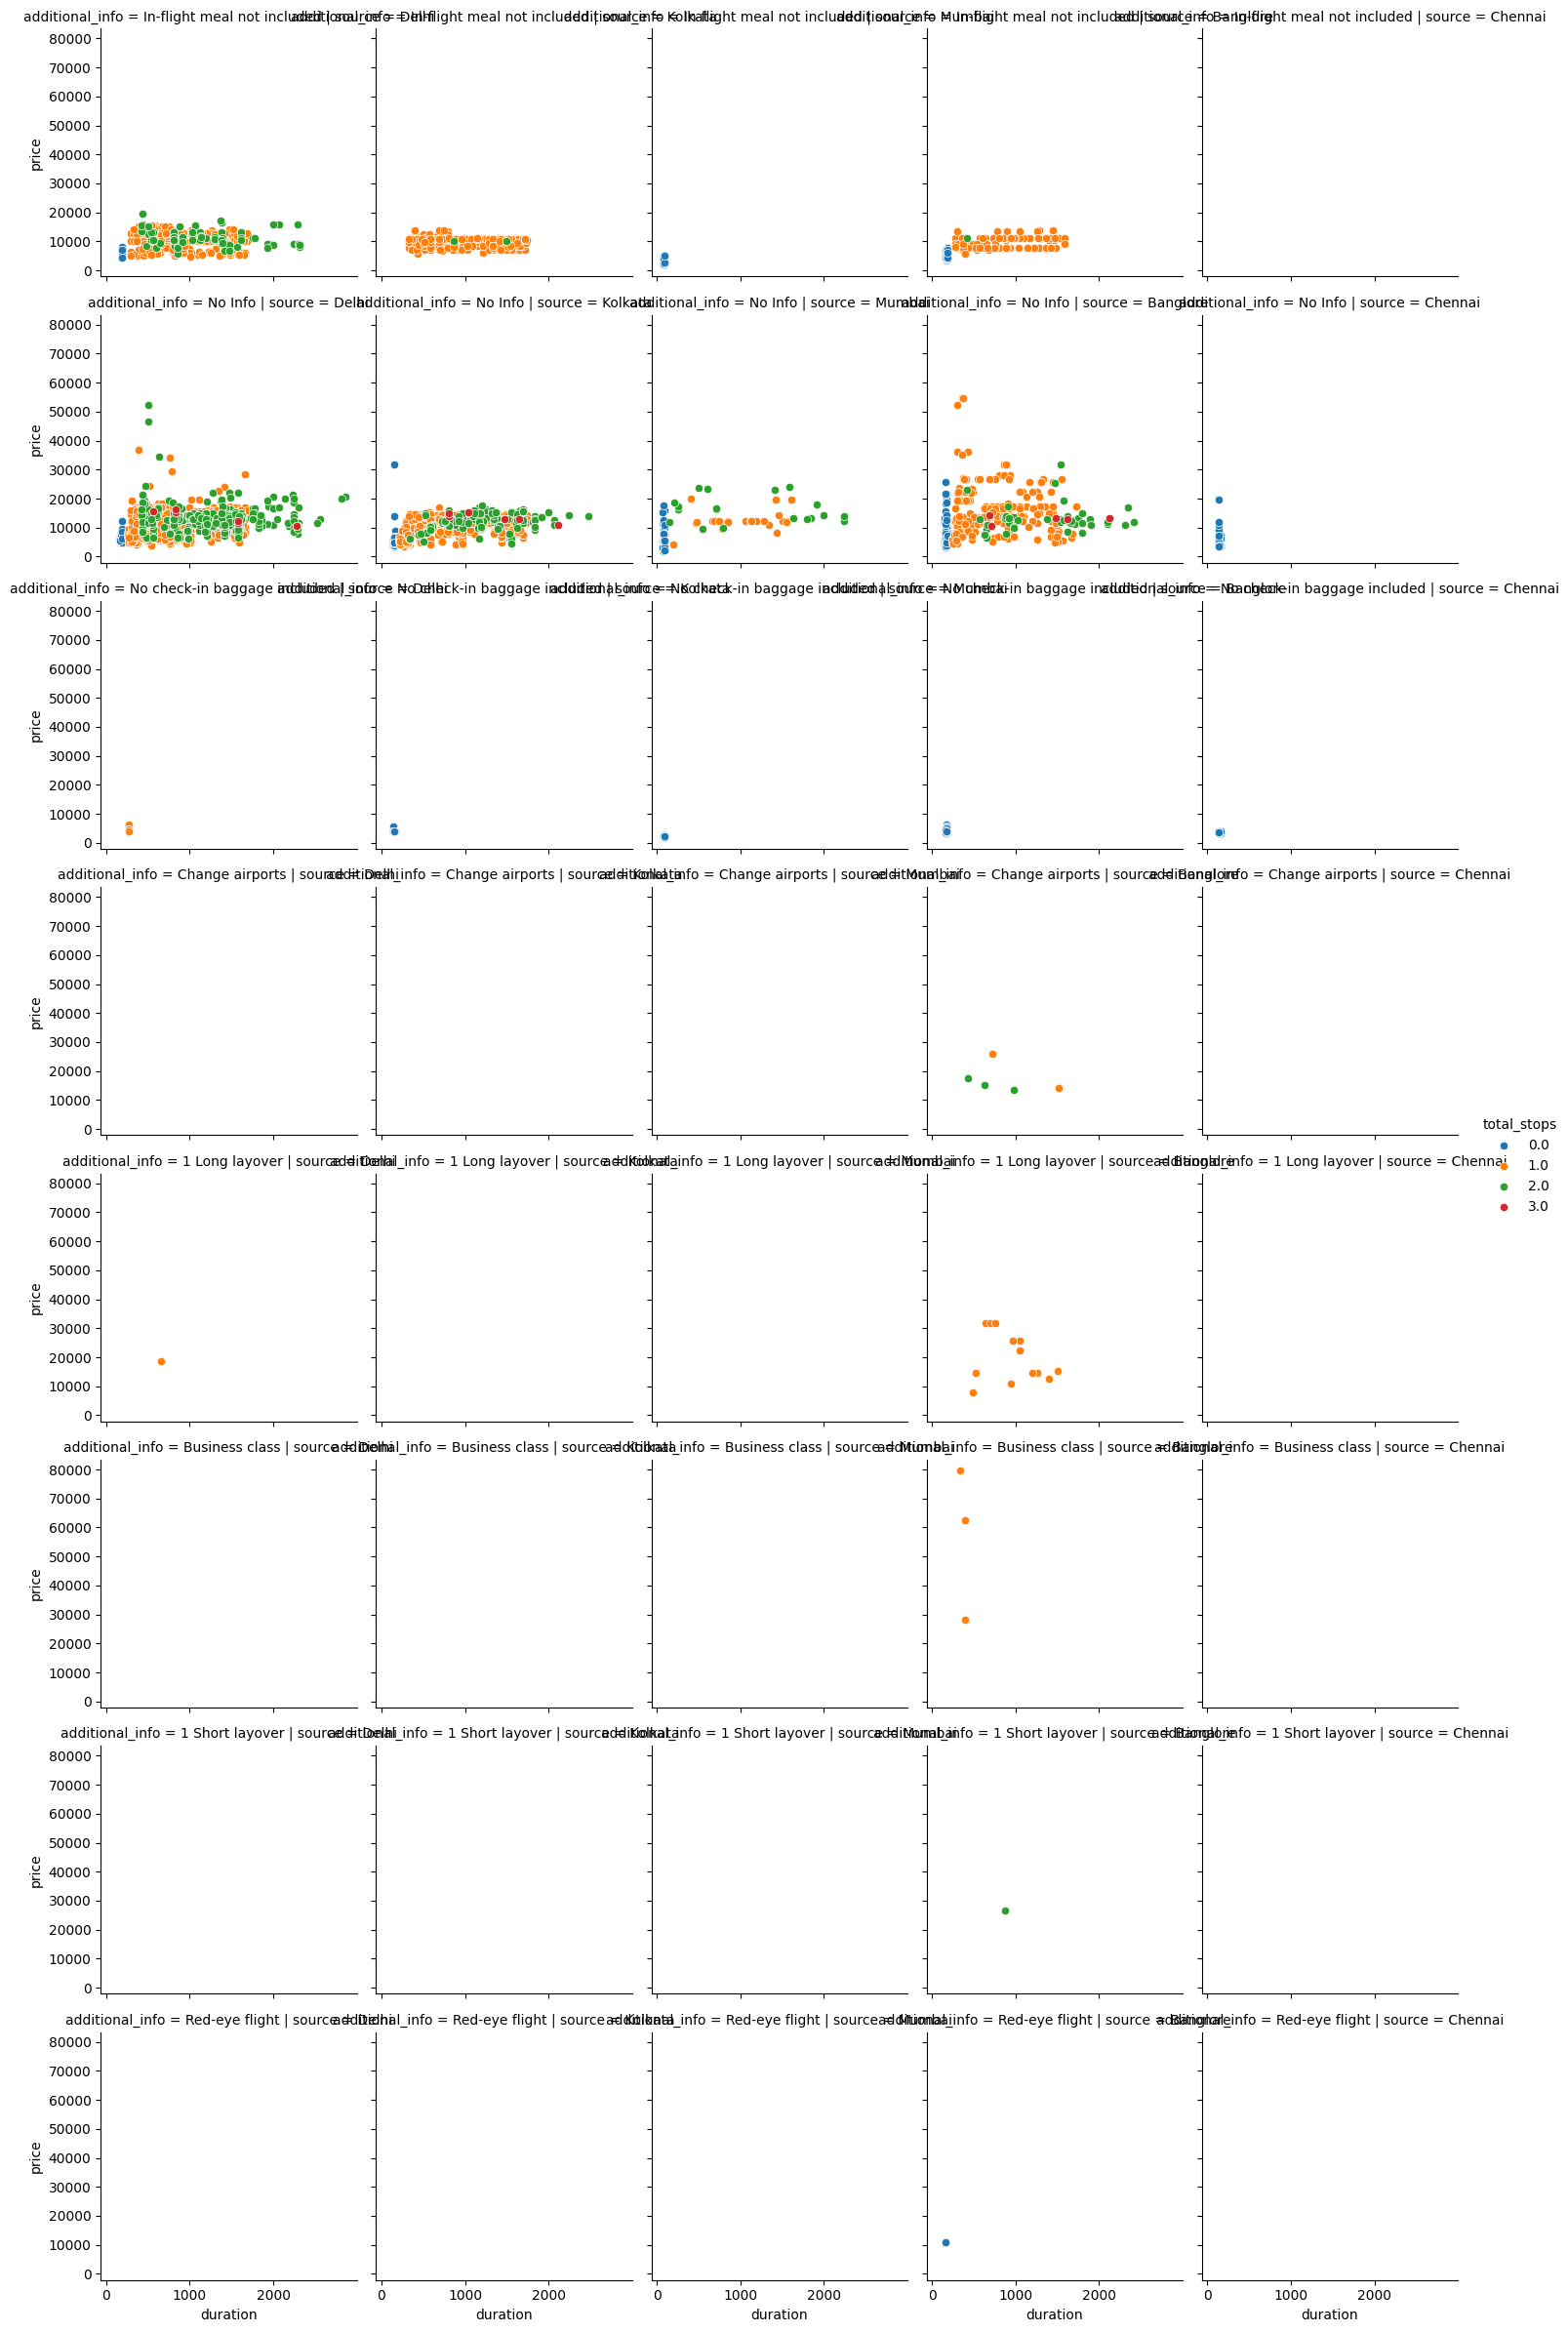

In [38]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	row="additional_info",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [39]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -962.5
Upper Limit : 2057.5


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
271,Air India,2019-05-15,Kolkata,Banglore,2024-10-06 05:50:00,2024-10-06 16:15:00,2065,2.0,No Info,12723
3687,Air India,2019-05-01,Kolkata,Banglore,2024-10-06 05:50:00,2024-10-06 16:15:00,2065,2.0,No Info,10991
6076,Jet Airways,2019-03-06,Delhi,Cochin,2024-10-06 17:55:00,2024-10-06 04:25:00,2070,2.0,No Info,17072
3223,Jet Airways,2019-03-06,Delhi,Cochin,2024-10-06 17:55:00,2024-10-06 04:25:00,2070,2.0,In-flight meal not included,15812
2988,Air India,2019-03-03,Banglore,New Delhi,2024-10-06 11:05:00,2024-10-06 22:10:00,2105,2.0,No Info,11791
1503,Air India,2019-03-18,Banglore,New Delhi,2024-10-06 11:05:00,2024-10-06 22:10:00,2105,2.0,No Info,11161
1346,Air India,2019-03-03,Banglore,New Delhi,2024-10-06 11:05:00,2024-10-06 22:10:00,2105,2.0,No Info,11948
730,Air India,2019-05-12,Kolkata,Banglore,2024-10-06 12:00:00,2024-10-06 23:15:00,2115,3.0,No Info,10991
2743,Air India,2019-03-12,Banglore,New Delhi,2024-10-06 06:45:00,2024-10-06 18:05:00,2120,3.0,No Info,13387
1138,Jet Airways,2019-03-06,Delhi,Cochin,2024-10-06 16:50:00,2024-10-06 04:25:00,2135,2.0,No Info,19907


### 8.5 additional_info

In [40]:
eda_helper_functions.cat_summary(train, "additional_info")

0       In-flight meal not included
1                           No Info
2                           No Info
3                           No Info
4                           No Info
                   ...             
6689                        No Info
6690                        No Info
6691                        No Info
6692                        No Info
6693                        No Info
Name: additional_info, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,8
top,No Info
freq,5226


,count,percentage
category,,
No Info,5226,0.780699
In-flight meal not included,1230,0.183747
No check-in baggage included,214,0.031969
1 Long layover,14,0.002091
Change airports,5,0.000747
Business class,3,0.000448
1 Short layover,1,0.000149
Red-eye flight,1,0.000149


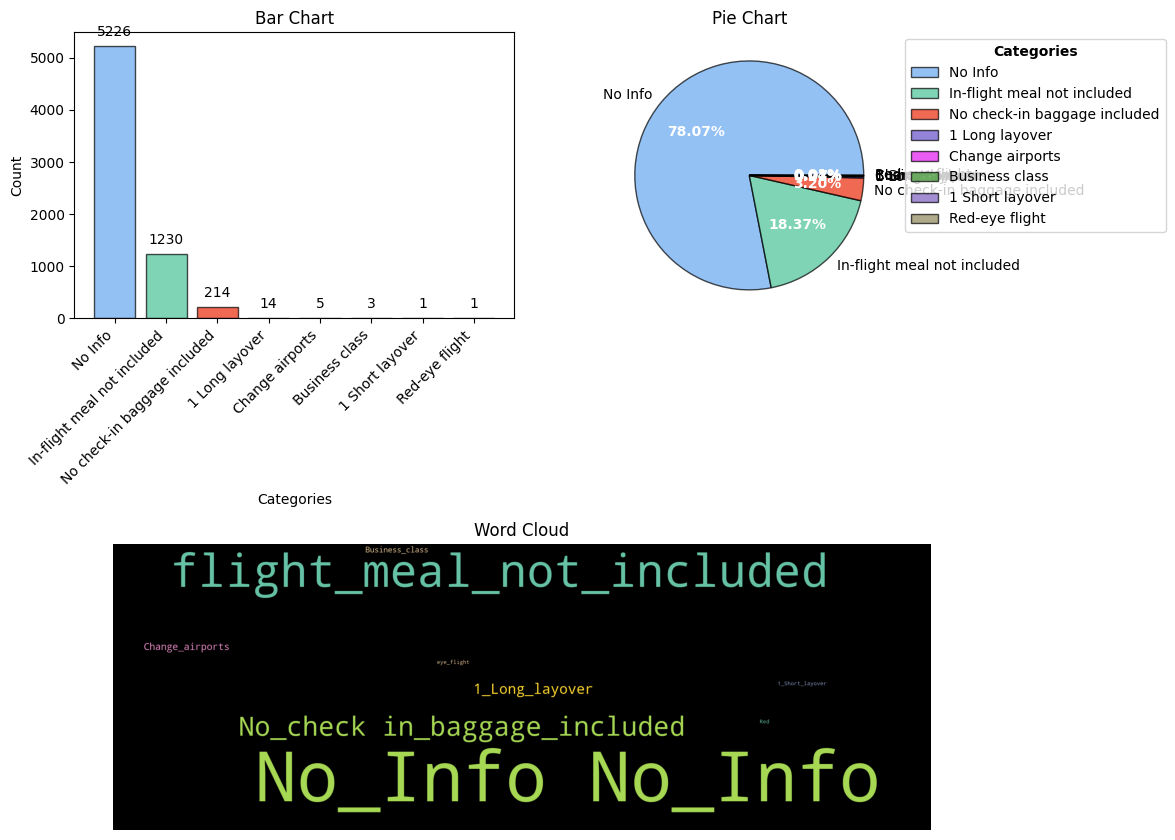

In [41]:
eda_helper_functions.cat_univar_plots(train, "additional_info")

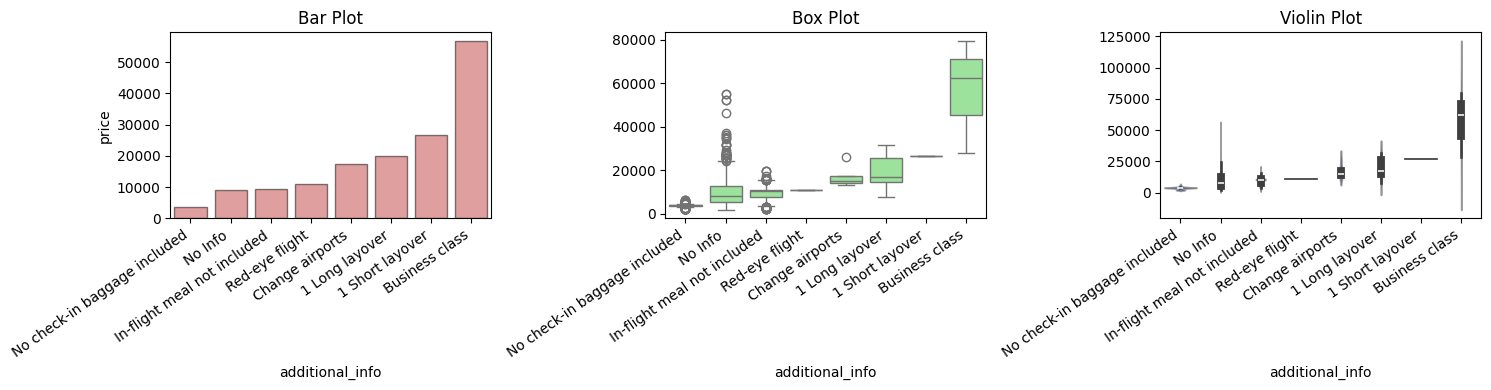

In [42]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")

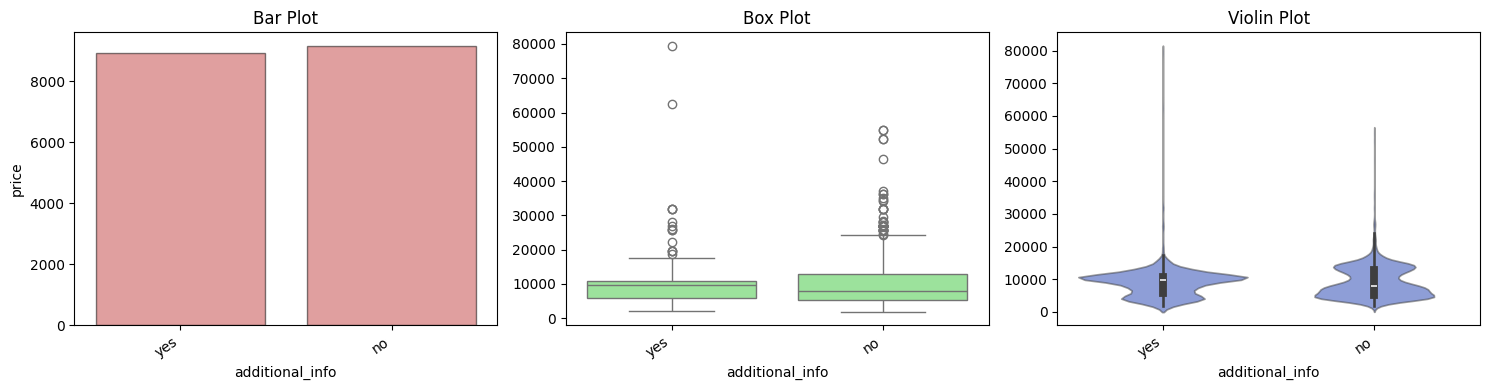

In [43]:
# convertion additional_info into a binary feature for analysis

(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)

- `additional_info` has severely rare categories
- Converted it into a binary feature for further analysis

## 9. Automated EDA

In [44]:
# from ydata_profiling import ProfileReport

In [45]:
# report = ProfileReport(train)

In [46]:
# report.to_file(output_file="output.html")